In [33]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from scipy.stats import zscore
from kneed import KneeLocator
from feature_engine import transformation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
mongo_uri = ""
client = MongoClient(mongo_uri, server_api=ServerApi('1'))

try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

ConfigurationError: The resolution lifetime expired after 21.224 seconds: Server Do53:192.168.51.168@53 answered The DNS operation timed out.; Server Do53:192.168.51.168@53 answered The DNS operation timed out.; Server Do53:192.168.51.168@53 answered The DNS operation timed out.; Server Do53:192.168.51.168@53 answered The DNS operation timed out.; Server Do53:192.168.51.168@53 answered The DNS operation timed out.; Server Do53:192.168.51.168@53 answered The DNS operation timed out.; Server Do53:192.168.51.168@53 answered The DNS operation timed out.

## Pre-processing the data
### First approach
The first approach I took was based on the advice from chat gpt. This gave a number of problems.
- Here I ended up with a dataframe where each row corresponded to a user and each column corresponded to a product. This did not provide any valuable information as we lost the usefulness of tagging each product and column names were also lost.
- Trying to find an elbow-point here was not fruitful. Most likely due to the fact that there was an extremely large number of dimensions and I had not done dimensionality reduction. The graph for elbow-point ended up being a constant downward linear trend, going nowhere even with 90+ clusters.
### Second approach
This approach accounts for the mistakes and misteps made in the second approach.
- Here the pre-processed data results in a data-frame where each user corresponds to a row and each column corresponds to some aspect of the clothign they have bought (color or a tag). These cells would have counts in them rather than being binary. This arrangement should drastically reduce the number of columns
- PCA will be performed to further reduce the dimensionality

In [ ]:
# # Load data and drop unnecessary columns
# db = client['test']
# products_collection = db['products']
# products_documents = products_collection.find()
# products_df = pd.DataFrame(products_documents)
# mod_products_df = products_df.drop(columns=['countInStock', 'price', '__v', 'createdAt', 'images','_id'])

# # Use MultiLabelBinarizer to create one-hot encoded columns for tags
# mlb = MultiLabelBinarizer()
# tags_encoded = mlb.fit_transform(mod_products_df['tags'])
# tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_, index=products_df.index)

# # Add the dataframe of tags to existing dataframe
# mod_products_df = pd.concat([mod_products_df, tags_df], axis=1)
# mod_products_df = products_df.drop(columns=['tags']) # Drop since its encoded
# # Load data and drop unnecessary columns
# db = client['test']
# orders_collection = db['orders']
# orders_documents = orders_collection.find()
# orders_df = pd.DataFrame(orders_documents)
# mod_orders_df = orders_df.drop(columns=['createdAt', 'deliveryStatus', '__v', '_id'])

# # Create a dictionary to map product IDs to row indices in the products_encoded_df
# product_id_to_idx = {}
# for idx, product in products_df.iterrows():
#     product_id_to_idx[str(product['_id'])] = idx
# product_id_to_idx

# # convert the orders data to a DataFrame
# order_rows = []
# for idx, order in orders_df.iterrows():
#     order_row = {}
#     order_row["createdBy"] = order['createdBy']
#     for product_id, item in order["items"].items():
#         if product_id in product_id_to_idx:
#             product_index = product_id_to_idx[product_id]
#             order_row[product_index] = item["qty"]
#     order_rows.append(order_row)

# # Create df, Group the orders data by customer and sum the purchases
# orders_df = pd.DataFrame(order_rows).fillna(0)
# customer_purchases_df = orders_df.groupby(orders_df['createdBy']).sum()
# customer_purchases_df = customer_purchases_df.reindex(sorted(customer_purchases_df.columns), axis=1)
# customer_purchases_df

In [35]:
# Load data and drop unnecessary columns
db = client['test']
products_collection = db['products']
products_documents = products_collection.find()
products_df = pd.DataFrame(products_documents)
mod_products_df = products_df.drop(columns=['countInStock', 'price', '__v', 'createdAt', 'images'])
mod_products_df['_id'] = mod_products_df['_id'].apply(lambda x : str(x)) 

# Iterate through the orders and match each order to the products they've bought
# Through that match each order to the tags and colors they've bought
# Then group by the user to get the final data frame  
orders_collection = db['orders']
orders_documents = orders_collection.find() 
orders_df = pd.DataFrame(orders_documents)
order_rows = []
for idx, order in orders_df.iterrows():
    row = {'createdBy': order['createdBy']}
    for pid, item in order['items'].items():
        product = mod_products_df.loc[mod_products_df['_id'] == pid]
        for _, color in product['color'].items():
            row[color] = 1
        for _, tags in product['tags'].items():
            for tag in tags:
                row[tag] = 1
    order_rows.append(row)

# Create df, Group the orders data by customer and sum the purchases
purchases_df = pd.DataFrame(order_rows).fillna(0)
purchases_df = purchases_df.groupby('createdBy').sum()
org_df = purchases_df.copy()

In [36]:
purchases_df = org_df.copy()

# Plot before removing outliers
def multi_boxplot(df):
    fig, ax = plt.subplots(1, len(df.columns), figsize=(120, 6))
    for col in df.columns: 
        col_idx = purchases_df.columns.get_loc(col)
        df.boxplot(col, ax=ax[col_idx])
    fig.show()
    
# Remove outliers
purchases_df = purchases_df[(np.abs(zscore(purchases_df)) <= 3).all(axis=1)]

## Choosing a clustering algorithm


In [42]:
# It is observed that all the columns have positive skew. We should compensate for this when preprocessing
# Plots before scaling and transforming
# purchases_df.hist(figsize=(120, 40))

# Yeojohnson transformation for each column
transformer = transformation.YeoJohnsonTransformer()
purchases_df = transformer.fit_transform(purchases_df)

# Standard scaling for all values
scaler = StandardScaler()
purchases_df = pd.DataFrame(scaler.fit_transform(purchases_df))
# TODO: Need to add the names back as they are lost in transformation

# Plots after scaling and transforming
# purchases_df.hist(figsize=(120, 40))

# Dimensionaltiy reduction to visualize the data
# pca = PCA(n_components=2)
# purchases_df = pd.DataFrame(pca.fit_transform(purchases_df))

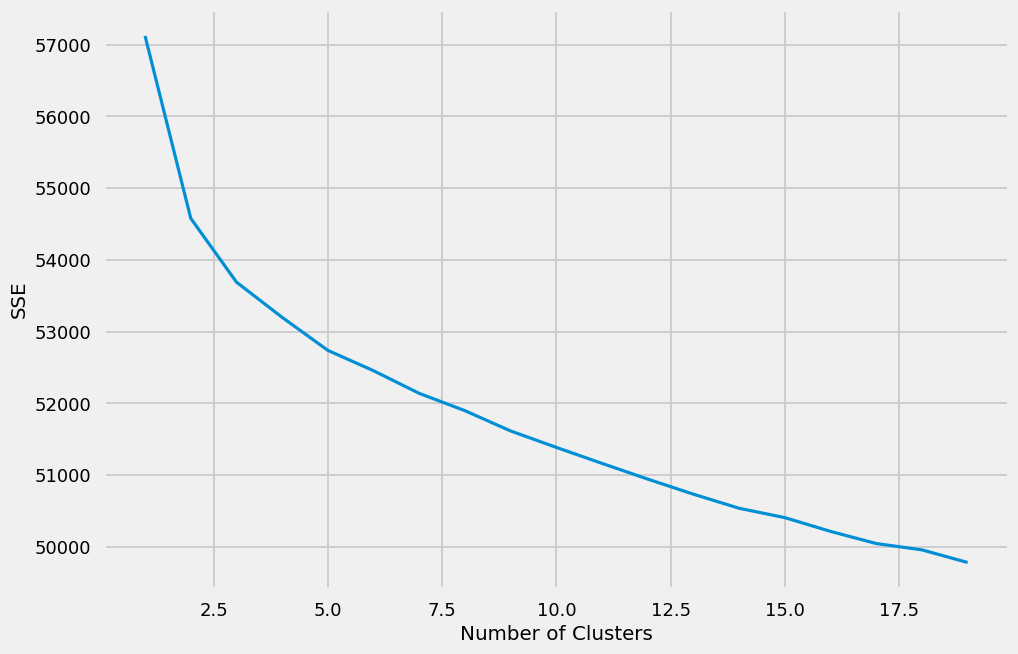

5

In [43]:
# Elbow method
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
}
tested_range = range(1, 20)

# A list holds the SSE values for each k
sse = []
for k in tested_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(purchases_df)
    sse.append(kmeans.inertia_)

plt.style.use("seaborn-v0_8-talk")
plt.plot(tested_range, sse)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

kl = KneeLocator(tested_range, sse, curve="convex", direction="decreasing")
kl.elbow

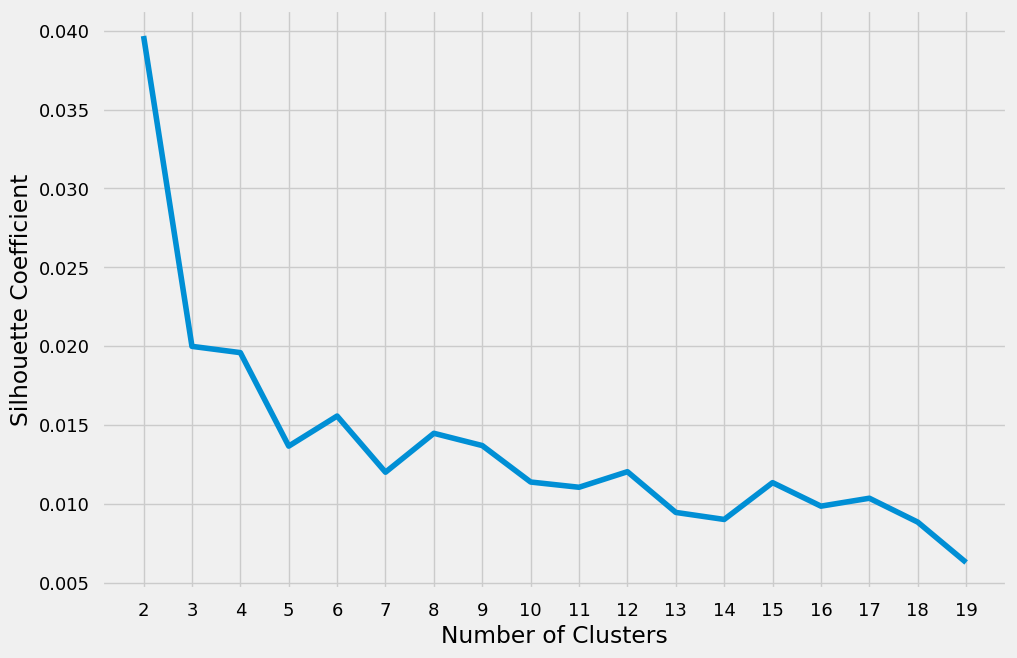

In [44]:
# Silhoutte score
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
}
tested_range = range(2, 20)
silhouette_coefficients = []
for k in tested_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(purchases_df)
    score = silhouette_score(purchases_df, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(tested_range, silhouette_coefficients)
plt.xticks(tested_range)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

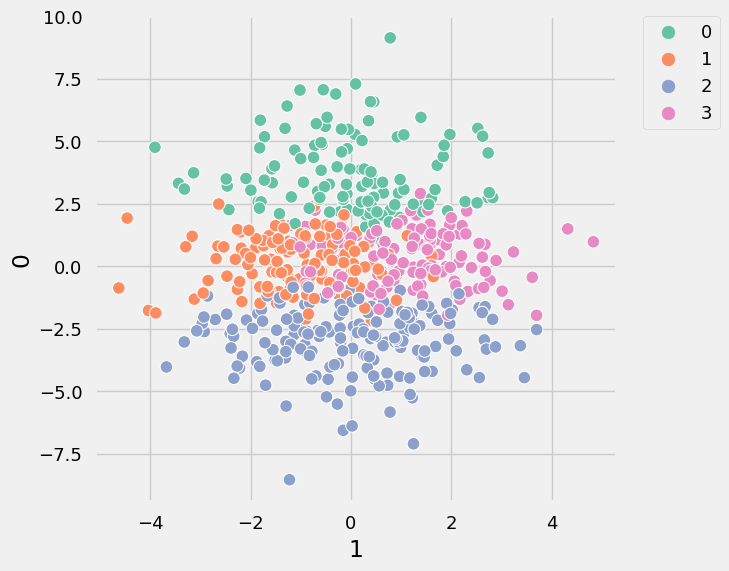

In [45]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
res = kmeans.fit(purchases_df).labels_

pca = PCA(n_components=2)
vis_df = pd.DataFrame(pca.fit_transform(purchases_df))

# Plot for all data
plt.figure(figsize=(6, 6))

vis_df['predicted_cluster'] = res

scat = sns.scatterplot(
    data=vis_df,
    x=1,
    y=0,
    palette="Set2",
    hue='predicted_cluster'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()